# Librerias

In [67]:
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import numpy as np 
import pandas as pd 
import os 

# pip install opencv-python
import cv2 

#importar las librerias necesarias
import tensorflow as tf
import keras
from keras import Model
from tensorflow.keras.applications.resnet50 import ResNet50
#from keras.preprocessing import image
import keras.utils as image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.layers import GlobalMaxPooling2D
tf.__version__

'2.11.0'

# Funciones

In [30]:
def mostrar_imagenes(figures, nrows = 1, ncols=1,figsize=(8, 8)):
    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows,figsize=figsize)
    for ind,title in enumerate(figures):
        axeslist.ravel()[ind].imshow(cv2.cvtColor(figures[title], cv2.COLOR_BGR2RGB))
        axeslist.ravel()[ind].set_title(title)
        axeslist.ravel()[ind].set_axis_off()
    plt.tight_layout() # optional

In [31]:
def cargar_imagen(img):
    return cv2.imread(ruta_imagen(img))

In [32]:
def load_image_2(img, resized_fac = 0.1):
    img     = cv2.imread(ruta_imagen(img))
    w, h, _ = img.shape
    resized = cv2.resize(img, (int(h*resized_fac), int(w*resized_fac)), interpolation = cv2.INTER_AREA)
    return resized

In [33]:
def ruta_imagen(img):
    return DATASET_PATH+"/images/"+img

# Lectura de datos

In [34]:
# DATASET_PATH = "../dataset/"
#OJO, las imagenes las saco de Git para que evitar lo que ocupan
DATASET_PATH = "C:/Users/Admin/Documents/GitHub_Publicos/imagenes/recomendar_imagenes/"
print(os.listdir(DATASET_PATH))

['images', 'styles.csv']


In [35]:
%%time
#leer el archivo
misdatos = pd.read_csv(DATASET_PATH + "styles.csv", on_bad_lines='skip')
#crear una columna con la imagen a partir del id y el nombre de la img que coinciden
misdatos['image'] = misdatos.apply(lambda row: str(row['id']) + ".jpg", axis=1)
misdatos = misdatos.reset_index(drop=True)
misdatos.shape

CPU times: total: 578 ms
Wall time: 563 ms


(44424, 11)

In [36]:
misdatos.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,53759.jpg


In [37]:
#como saber las dimensiones de una imagen
img = cv2.imread('../dataset/images/10000.jpg') 
wid = img.shape[1] 
hgt = img.shape[0] 
print(str(wid) + "x" + str(hgt))

60x80


CPU times: total: 328 ms
Wall time: 348 ms


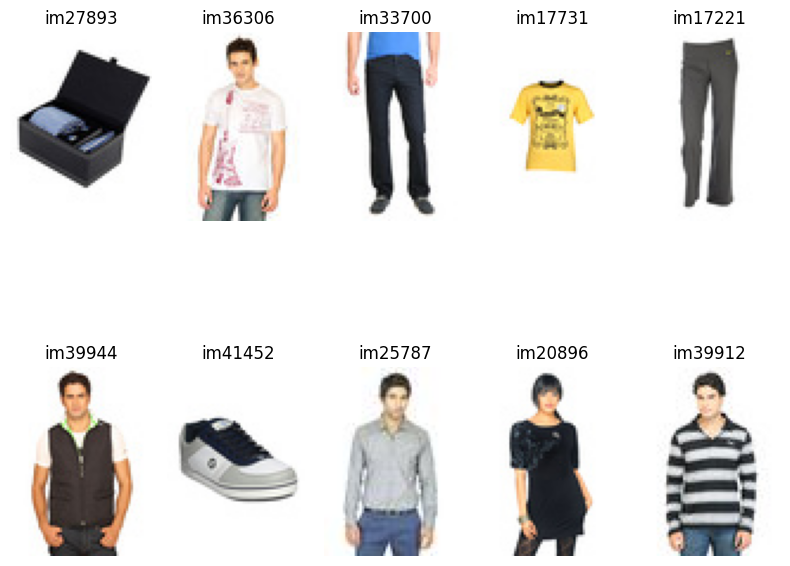

In [38]:
%%time
num_imagenes = 10
figures = {'im'+str(i): cargar_imagen(row.image) for i, row in misdatos.sample(num_imagenes).iterrows()}
mostrar_imagenes(figures, 2, 5)

# Limpieza de datos

In [39]:
data = misdatos.copy()
data.shape

(44424, 11)

In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44424 entries, 0 to 44423
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  44424 non-null  int64  
 1   gender              44424 non-null  object 
 2   masterCategory      44424 non-null  object 
 3   subCategory         44424 non-null  object 
 4   articleType         44424 non-null  object 
 5   baseColour          44409 non-null  object 
 6   season              44403 non-null  object 
 7   year                44423 non-null  float64
 8   usage               44107 non-null  object 
 9   productDisplayName  44417 non-null  object 
 10  image               44424 non-null  object 
dtypes: float64(1), int64(1), object(9)
memory usage: 3.7+ MB


In [42]:
# renombrar las columnas del dataframe
data.rename(columns = {'gender' : 'genero',
                           'masterCategory' : 'categoria',
                           'subCategory' : 'sub_categoria', 
                           'articleType' : 'tipo_producto', 
                           'baseColour' : 'color', 
                           'season' : 'estacion', 
                           'year' : 'año',
                           'usage' : 'uso',
                           'productDisplayName' : 'nombre_producto', 
                           'image' : 'imagen'
                           }, inplace = True)
data.columns

Index(['id', 'genero', 'categoria', 'sub_categoria', 'tipo_producto', 'color',
       'estacion', 'año', 'uso', 'nombre_producto', 'imagen'],
      dtype='object')

In [43]:
# Identificamos el número de missing values en cada columna
data.isnull().sum()

id                   0
genero               0
categoria            0
sub_categoria        0
tipo_producto        0
color               15
estacion            21
año                  1
uso                317
nombre_producto      7
imagen               0
dtype: int64

## Variables

In [44]:
data.dtypes

id                   int64
genero              object
categoria           object
sub_categoria       object
tipo_producto       object
color               object
estacion            object
año                float64
uso                 object
nombre_producto     object
imagen              object
dtype: object

### genero

In [22]:
data['genero'].value_counts()

Men       22147
Women     18631
Unisex     2161
Boys        830
Girls       655
Name: genero, dtype: int64

### categoria

In [24]:
data['categoria'].value_counts()

Apparel           21397
Accessories       11274
Footwear           9219
Personal Care      2403
Free Items          105
Sporting Goods       25
Home                  1
Name: categoria, dtype: int64

### subcategoria

In [45]:
data['sub_categoria'].value_counts()

Topwear                     15402
Shoes                        7343
Bags                         3055
Bottomwear                   2694
Watches                      2542
Innerwear                    1808
Jewellery                    1079
Eyewear                      1073
Fragrance                    1011
Sandal                        963
Wallets                       933
Flip Flops                    913
Belts                         811
Socks                         698
Lips                          527
Dress                         478
Loungewear and Nightwear      470
Saree                         427
Nails                         329
Makeup                        307
Headwear                      293
Ties                          258
Accessories                   129
Scarves                       118
Cufflinks                     108
Apparel Set                   106
Free Gifts                    104
Stoles                         90
Skin Care                      77
Skin          

### tipo_producto

In [46]:
data['tipo_producto'].value_counts()

Tshirts                7067
Shirts                 3217
Casual Shoes           2845
Watches                2542
Sports Shoes           2036
                       ... 
Shoe Laces                1
Mens Grooming Kit         1
Body Wash and Scrub       1
Suits                     1
Ipad                      1
Name: tipo_producto, Length: 143, dtype: int64

### color

In [47]:
data['color'].value_counts()

Black                9728
White                5538
Blue                 4918
Brown                3494
Grey                 2741
Red                  2455
Green                2115
Pink                 1860
Navy Blue            1789
Purple               1640
Silver               1090
Yellow                778
Beige                 749
Gold                  628
Maroon                581
Orange                530
Olive                 410
Multi                 394
Cream                 390
Steel                 315
Charcoal              228
Peach                 195
Off White             182
Skin                  179
Lavender              162
Grey Melange          146
Khaki                 139
Magenta               129
Teal                  120
Tan                   114
Mustard                97
Bronze                 95
Copper                 86
Turquoise Blue         69
Rust                   66
Burgundy               45
Metallic               43
Coffee Brown           31
Mauve       

In [57]:
#sustituir valores nulos por el valor 'Black'
data["color"].fillna('Black', inplace = True)

### estacion

In [48]:
data['estacion'].value_counts()

Summer    21472
Fall      11431
Winter     8517
Spring     2983
Name: estacion, dtype: int64

In [58]:
#sustituir valores nulos por el valor 'Summer'
data["estacion"].fillna('Summer', inplace = True)

### año

In [49]:
data['año'].value_counts()

2012.0    16288
2011.0    13672
2016.0     6006
2017.0     2916
2015.0     2780
2013.0     1212
2010.0      846
2018.0      405
2014.0      236
2019.0       33
2009.0       20
2008.0        7
2007.0        2
Name: año, dtype: int64

In [53]:
#sustituir valores nulos por el valor '2012'
data["año"].fillna(2012, inplace = True)

In [54]:
data['año'] = data['año'].astype('int64')

### uso

In [56]:
data['uso'].value_counts()

Casual          34406
Sports           4025
Ethnic           3208
Formal           2345
Smart Casual       67
Party              29
Travel             26
Home                1
Name: uso, dtype: int64

In [59]:
#sustituir valores nulos por el valor 'Casual'
data["uso"].fillna('Casual', inplace = True)

### nombre_producto

In [60]:
data['nombre_producto'].value_counts()

Lucera Women Silver Earrings                         82
Lucera Women Silver Pendant                          56
Lucera Women Silver Ring                             50
Catwalk Women Black Heels                            48
Q&Q Men Black Dial Watch                             42
                                                     ..
Lino Perros Women Leatherite Blue Handbag             1
Lakme True Wear Freespirit Nail Polish N525           1
Jungle Book Boys Follow The Tracks Yellow T-shirt     1
Spykar Men Navy Blue Trevor Brief                     1
Fossil Women Pink Dial Chronograph Watch ES3050       1
Name: nombre_producto, Length: 31121, dtype: int64

In [61]:
#sustituir valores nulos por el valor 'desconocido'
data["nombre_producto"].fillna('desconocido', inplace = True)

# Algoritmo 

In [68]:
%%time
# Entrenar el modelo
img_width,img_height,_ = 224,224,3
base_model = ResNet50(weights = 'imagenet',
                   include_top = False,
                   input_shape = (img_width,img_height,3))

# Add Layer Embedding
model = tf.keras.Sequential([
    base_model,
    GlobalMaxPooling2D()
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_max_pooling2d_1 (Glo  (None, 2048)             0         
 balMaxPooling2D)                                                
                                                                 
Total params: 23,587,712
Trainable params: 23,534,592
Non-trainable params: 53,120
_________________________________________________________________
CPU times: total: 4.08 s
Wall time: 2.56 s


In [69]:
def get_embedding(model, img_name):
    # Reshape
    img = image.load_img(ruta_imagen(img_name), target_size=(img_width, img_height))
    # img to Array
    x   = image.img_to_array(img)
    # Expand Dim (1, w, h)
    x   = np.expand_dims(x, axis=0)
    # Pre process Input
    x   = preprocess_input(x)
    return model.predict(x).reshape(-1)

In [73]:
%%time
emb = get_embedding(model, data.iloc[0].imagen)
emb.shape

1/1 [==============================] - 2s 2s/step
CPU times: total: 2.02 s
Wall time: 1.78 s


(2048,)

(80, 60, 3)
[ 2.2286458  6.7580338  0.        ...  2.485375   2.5894732 18.34449  ]
CPU times: total: 15.6 ms
Wall time: 26 ms


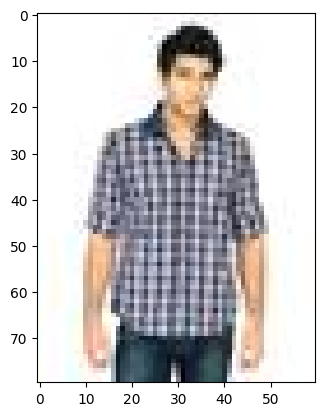

In [75]:
%%time
#probar con una imagen
img_array = cargar_imagen(data.iloc[0].imagen)
plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
print(img_array.shape)
print(emb)

In [77]:
#probar con las primeras 5000 imagenes 
df = data.copy()
df = df.sample(5000)
df.shape 

(5000, 11)

In [79]:
%%time
import swifter
#con el data completo
map_embeddings = df['imagen'].apply(lambda img: get_embedding(model, img))
#con el data sample
#map_embeddings = data_sample['image'].apply(lambda img: get_embedding(model, img))
df_embs = map_embeddings.apply(pd.Series)
# print(df_embs.shape)
df_embs.head()

1/1 [==============================] - 0s 288ms/step
CPU times: total: 1h 20min 19s
Wall time: 20min 49s


,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
14003,1.451187,0.000000,0.921588,0.000000,4.141328,0.000000,14.104146,6.253627,2.489088,0.000000,...,2.892138,3.990452,0.774357,1.908959,4.639800,2.639455,6.236462,6.288305,6.578648,5.287564
37612,2.837716,1.738768,3.646231,0.717859,1.422702,0.000000,9.208778,0.724913,0.852393,0.000000,...,0.000000,4.129922,5.708621,0.657851,2.726372,6.843935,10.326301,8.119919,0.000000,5.656154
29548,0.000000,0.361765,0.000000,0.000000,4.362873,4.226630,7.254994,1.162532,0.000000,0.000000,...,3.126545,0.000000,0.712664,0.000000,1.700461,0.000000,21.137484,5.013528,0.769120,0.000000
3178,6.214802,10.344787,0.262768,0.448729,9.810883,3.267552,2.385052,0.580626,0.181651,0.013768,...,6.168208,5.561082,2.596271,36.304119,17.103613,0.144690,11.160599,1.649812,9.658978,9.363388
30056,0.322609,1.365343,5.124692,5.151377,14.450071,0.000000,10.238176,9.109030,2.732350,0.000000,...,0.000000,6.567141,6.994685,1.250356,4.675283,0.382283,21.243210,6.089164,26.817362,7.935460


In [83]:
%%time

#compute cosine similarity

# pip install scikit-learn
from sklearn.metrics.pairwise import pairwise_distances

# Calcule DIstance Matriz
cosine_sim = 1-pairwise_distances(df_embs, metric='cosine')
cosine_sim[:4, :4]

CPU times: total: 7.38 s
Wall time: 2.54 s


array([[0.99999976, 0.67142177, 0.5990159 , 0.52942115],
       [0.67142177, 0.9999989 , 0.5950566 , 0.47353655],
       [0.5990159 , 0.5950566 , 1.        , 0.5129767 ],
       [0.52942115, 0.47353655, 0.5129767 , 1.        ]], dtype=float32)

# Recomendador de imagenes

In [84]:
indices = pd.Series(range(len(df)), index=df.index)
indices

14003       0
37612       1
29548       2
3178        3
30056       4
         ... 
19187    4995
42970    4996
12329    4997
28787    4998
22037    4999
Length: 5000, dtype: int64

In [85]:
# Function that get movie recommendations based on the cosine similarity score of movie genres
def get_recommender(idx, df, top_n = 5):
    sim_idx    = indices[idx]
    sim_scores = list(enumerate(cosine_sim[sim_idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    idx_rec    = [i[0] for i in sim_scores]
    idx_sim    = [i[1] for i in sim_scores]
    
    return indices.iloc[idx_rec].index, idx_sim

## Prueba 1

In [87]:
#seleccionar la imagen
id_img = 14003
#seleccionar el indice de la imagen
id_indice = 0

In [88]:
get_recommender(id_img, df, top_n = 5)

(Int64Index([37820, 19292, 9231, 43959, 12973], dtype='int64'),
 [0.82899594, 0.82876277, 0.8261118, 0.82426125, 0.81820583])

CPU times: total: 250 ms
Wall time: 281 ms


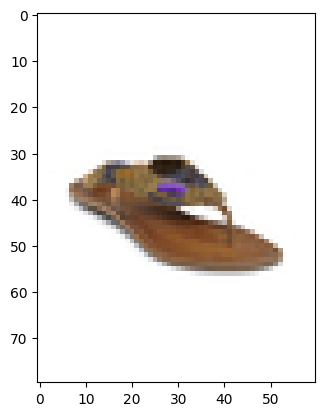

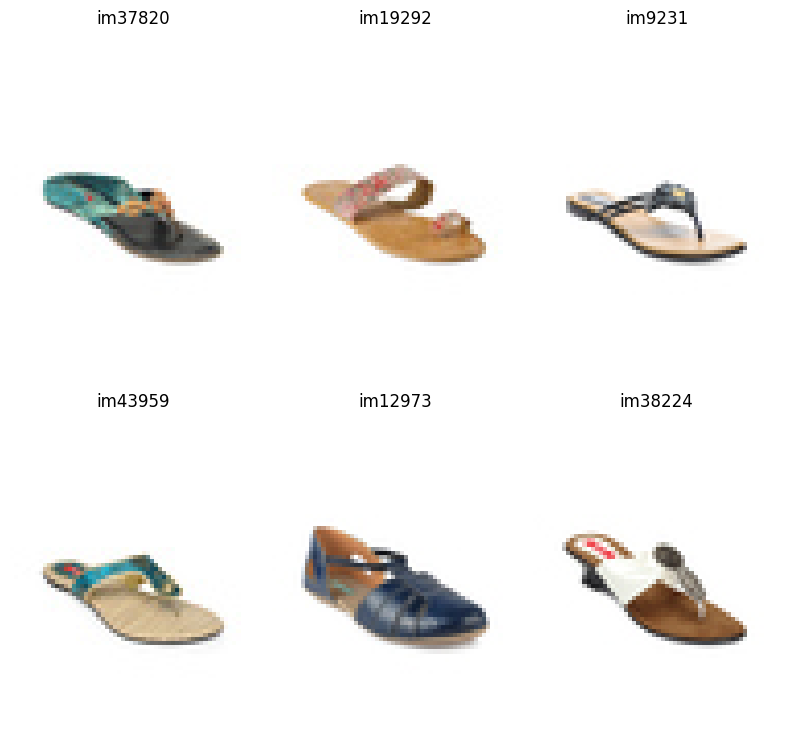

In [90]:
%%time

# Recommendations
idx_rec, idx_sim = get_recommender(id_img, df, top_n = 6)

# Plot
#===================
#plt.imshow(cv2.cvtColor(cargar_imagen(data_sample2.iloc[idx_ref].image), cv2.COLOR_BGR2RGB))
img_array = cargar_imagen(df.iloc[id_indice].imagen) #indicar el indice
plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
# generation of a dictionary of (title, images)
figures = {'im'+str(i): cargar_imagen(row.imagen) for i, row in df.loc[idx_rec].iterrows()}
# plot of the images in a figure, with 2 rows and 3 columns
mostrar_imagenes(figures, 2, 3)

## Prueba 2

In [91]:
#seleccionar la imagen
id_img = 37612
#seleccionar el indice de la imagen
id_indice = 1

In [92]:
get_recommender(id_img, df, top_n = 5)

(Int64Index([42579, 3422, 12819, 18584, 6543], dtype='int64'),
 [0.8403629, 0.8380501, 0.8357817, 0.8348676, 0.83086646])

CPU times: total: 219 ms
Wall time: 240 ms


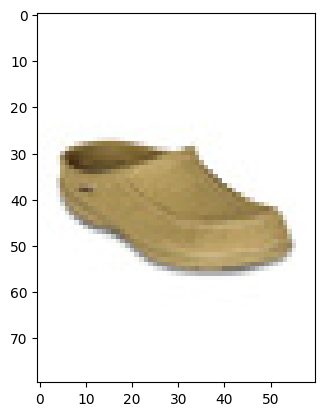

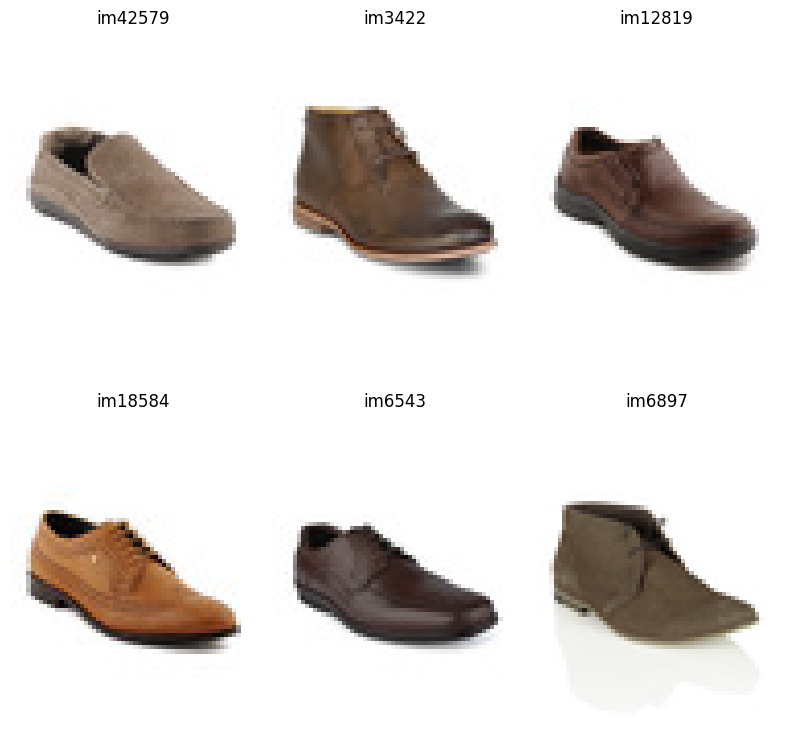

In [93]:
%%time

# Recommendations
idx_rec, idx_sim = get_recommender(id_img, df, top_n = 6)

# Plot
#===================
#plt.imshow(cv2.cvtColor(cargar_imagen(data_sample2.iloc[idx_ref].image), cv2.COLOR_BGR2RGB))
img_array = cargar_imagen(df.iloc[id_indice].imagen) #indicar el indice
plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
# generation of a dictionary of (title, images)
figures = {'im'+str(i): cargar_imagen(row.imagen) for i, row in df.loc[idx_rec].iterrows()}
# plot of the images in a figure, with 2 rows and 3 columns
mostrar_imagenes(figures, 2, 3)

## Prueba 3

In [97]:
#seleccionar la imagen
id_img = 3178
#seleccionar el indice de la imagen
id_indice = 3

In [98]:
get_recommender(id_img, df, top_n = 5)

(Int64Index([41725, 41762, 36473, 27150, 1569], dtype='int64'),
 [0.87765807, 0.85654914, 0.85527414, 0.8549358, 0.8546927])

CPU times: total: 266 ms
Wall time: 251 ms


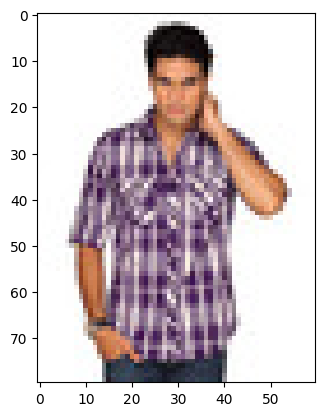

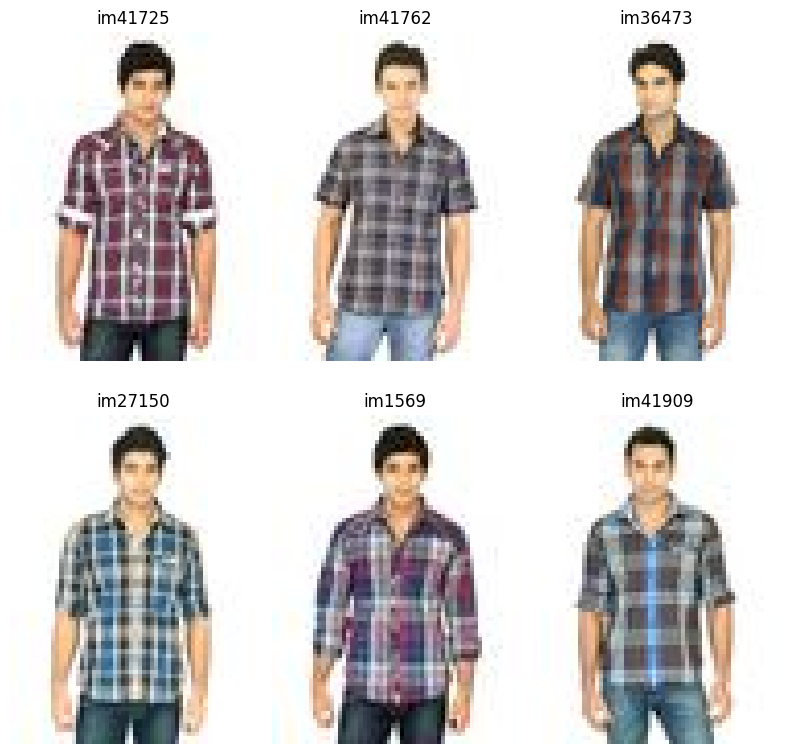

In [99]:
%%time

# Recommendations
idx_rec, idx_sim = get_recommender(id_img, df, top_n = 6)

# Plot
#===================
#plt.imshow(cv2.cvtColor(cargar_imagen(data_sample2.iloc[idx_ref].image), cv2.COLOR_BGR2RGB))
img_array = cargar_imagen(df.iloc[id_indice].imagen) #indicar el indice
plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
# generation of a dictionary of (title, images)
figures = {'im'+str(i): cargar_imagen(row.imagen) for i, row in df.loc[idx_rec].iterrows()}
# plot of the images in a figure, with 2 rows and 3 columns
mostrar_imagenes(figures, 2, 3)